$$\text{
Importing the Necessary Libraries
}
$$

In [2]:
###-----------------
### Import Libraries
###-----------------
import sys


sys.path.append('../')

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import datasets 
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report

import tensorflow as tf


from utils.helper import fn_plot_tf_hist, fn_plot_confusion_matrix


$$\text{
Setting Global Varables
}
$$

In [ ]:
###----------------
# Global Variables
###----------------


RANDOM_STATE = 0
np.random.seed(RANDOM_STATE)



TEST_SIZE =  0.2
ALPHA = 0.001
EPOCHS = 20
BATCH_SIZE = 32
PATIENCE = 6
LR_FACTOR = 0.1
LR_PATIENCE = 10

# set location of input files and output files
inpDir = '../input'
outDir = '../output'
modelDir = '../models' 
subDir = 'mnist_fashion'


# Set plotting parameters
params = {
    'figure.figsize': (15,4),
    'axes.titlesize': 'large',
    'axes.labelsize': 'medium',
    'legend.fontsize': 'medium',
    'xtick.labelsize': 'medium',
    'ytick.labelsize': 'medium',
}
plt.rcParams.update(params)


CMAP = plt.cm.coolwarm
plt.style.use('seaborn-v0_8-darkgrid')




In [4]:
def accuracy_socre_confusion_matrix(data_ds, prediction_model, labels):
    y_true, y_pred = [], []
    for count, data in enumerate(data_ds):
        feat, label = data
        pred = prediction_model(feat).numpy().argmax(axis=1)
        y_true.extend(label)
        y_pred.extend(pred)
        
    print(len(y_true), len(y_pred))

    print(accuracy_score(y_true=y_true, y_pred=y_pred)*100)

    fn_plot_confusion_matrix(y_true, y_pred, labels=labels)

$$\text{
    Loading the data
}
$$

In [5]:
train_filename = os.path.join(inpDir, 'fashion_mnist', 'fashion-mnist_train.csv')
valid_filename = os.path.join(inpDir, 'fashion_mnist', 'fashion-mnist_test.csv')

train_df = pd.read_csv(train_filename, header = 0)
valid_df = pd.read_csv(valid_filename, header = 0)


train_df.shape, valid_df.shape

((60000, 785), (10000, 785))

In [6]:
class_names = {
    0: 'T-shirt/top',
    1:'Trouser',
    2:'Pullover',
    3:'Dress',
    4:'Coat',
    5:'Sandal', 
    6: 'Shirt',
    7: 'Sneaker', 
    8:'Bag', 
    9: 'Ankle boot'
}

In [7]:
train_df.head(3)

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0


$$
\text{
    Plot the Images
}$$

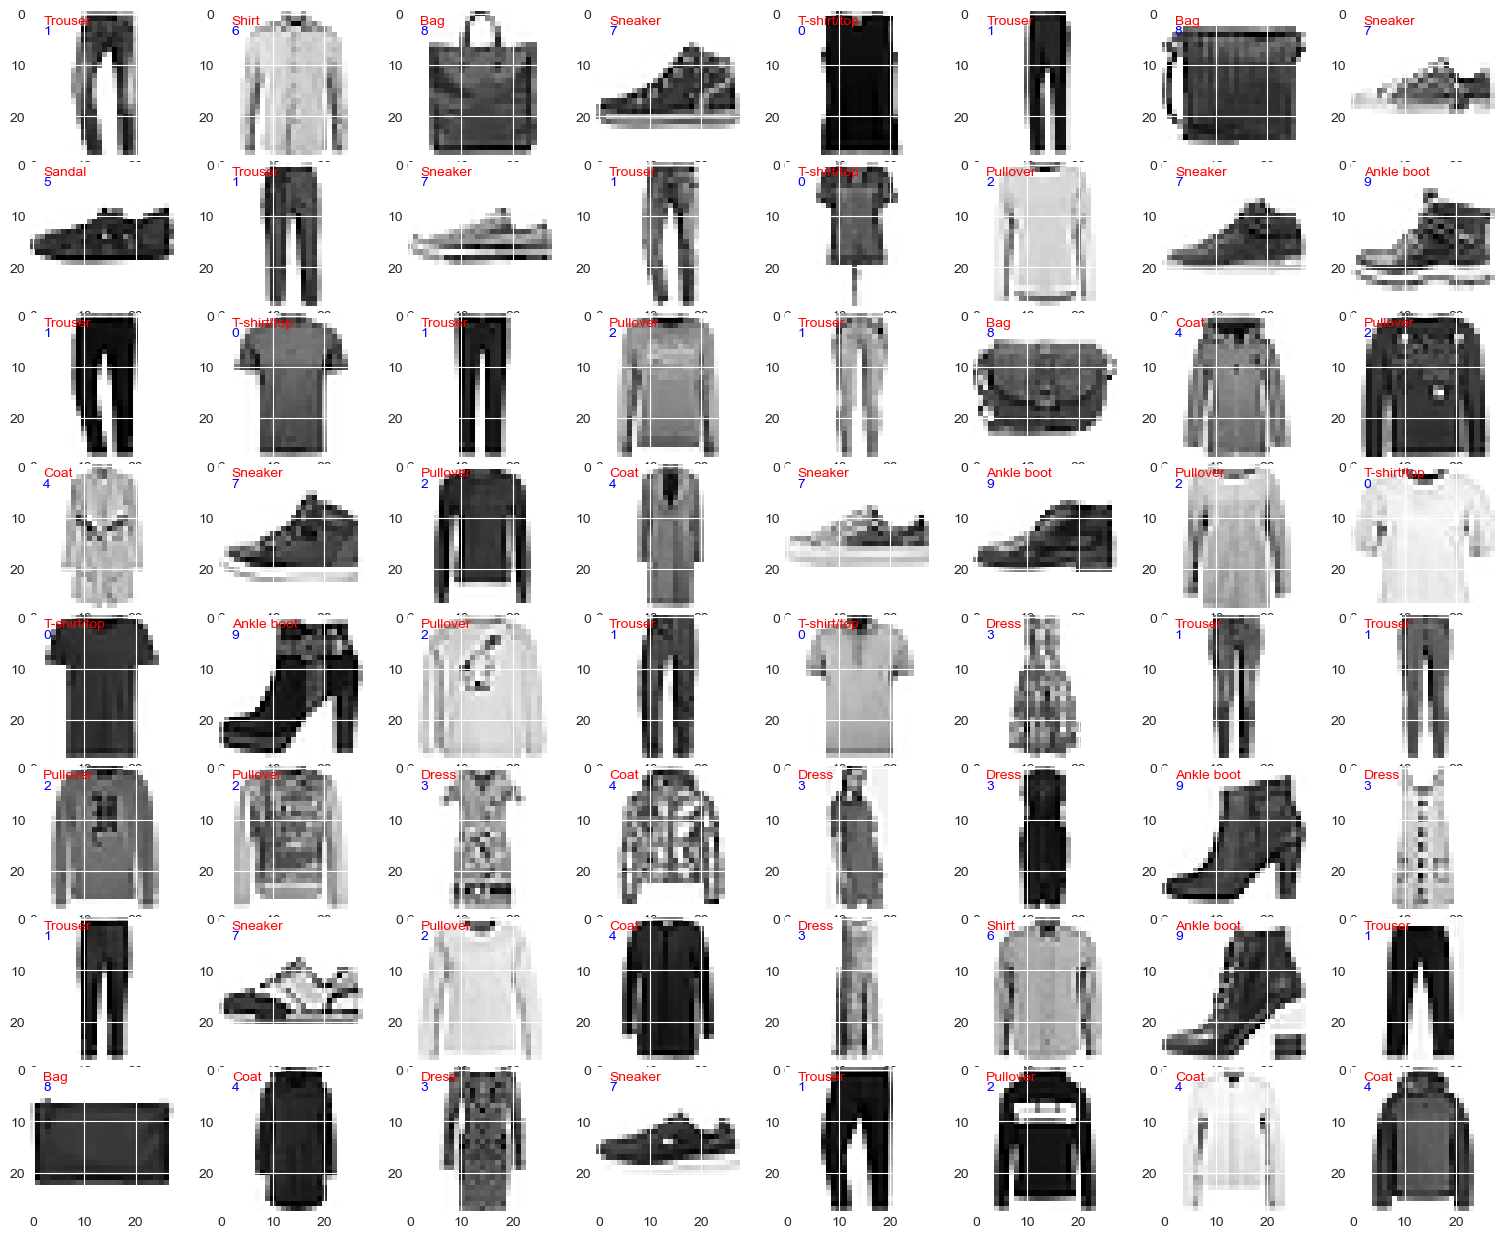

In [8]:
no_rows = 8
no_cols = 8

plot_df = train_df.sample(no_rows*no_cols)

fig = plt.figure(figsize=(15,12))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
i = 0

for idx, row in plot_df.iterrows():
    i += 1
    image  = row.values[1:].reshape(28,28)
    ax = fig.add_subplot(no_rows, no_cols, i)
    ax.imshow(image, cmap=plt.cm.binary, interpolation='nearest')
    ax.text(2,4, str(row.values[0]),color='b', fontsize=10)
    ax.text(2,2, class_names[row.values[0]],color='r', fontsize=10)

plt.show()  


$$\text{
    Train Test Split
}
$$

In [9]:
X_data = train_df.drop(columns=['label'], axis=1).to_numpy()
y_data = train_df['label'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=TEST_SIZE, random_state=RANDOM_STATE)

X_valid = valid_df.drop(columns=['label'], axis=1).to_numpy()
y_valid = valid_df['label'].to_numpy()


X_train.shape, X_test.shape, y_train.shape, y_test.shape 

((48000, 784), (12000, 784), (48000,), (12000,))

$$\text{
    Scaling the Dataset
}
$$

In [10]:
X_train = X_train/255.0
X_test = X_test/255.0
X_valid = X_valid/255.0

$$
\text{
Converting to dataset for batch processing instead of all data training at once
}
$$

In [11]:
train_ds = tf.data.Dataset.from_tensor_slices((X_train,y_train))
test_ds = tf.data.Dataset.from_tensor_slices((X_test,y_test))
valid_ds = tf.data.Dataset.from_tensor_slices((X_valid,y_valid))

type(train_ds), type(test_ds), type(valid_ds)

(tensorflow.python.data.ops.from_tensor_slices_op._TensorSliceDataset,
 tensorflow.python.data.ops.from_tensor_slices_op._TensorSliceDataset,
 tensorflow.python.data.ops.from_tensor_slices_op._TensorSliceDataset)

In [12]:
train_shape = X_train.shape
test_shape = X_test.shape
valid_shape = X_valid.shape

in_len = train_shape[1]
out_len = len(np.unique(y_train))

In [13]:
import gc

# del train_df, valid_df, X_train, y_train, X_test, y_test, X_valid, y_valid
gc.collect()
gc.collect()

0

$$
\text{
    Converting the data to a tensor dataset using Preprocessing and Batching
}
$$

In [14]:
train_ds = train_ds.shuffle(buffer_size = train_shape[0]).batch(BATCH_SIZE)
test_ds = test_ds.shuffle(buffer_size = test_shape[0]).batch(BATCH_SIZE)
valid_ds = valid_ds.shuffle(buffer_size = valid_shape[0]).batch(BATCH_SIZE)

In [15]:
train_ds = train_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
valid_ds = valid_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

In [16]:
# ONly for testing
next(iter(train_ds))

(<tf.Tensor: shape=(32, 784), dtype=float64, numpy=
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])>,
 <tf.Tensor: shape=(32,), dtype=int64, numpy=
 array([3, 3, 0, 7, 8, 4, 6, 0, 3, 5, 0, 3, 9, 8, 3, 8, 6, 8, 3, 1, 2, 3,
        8, 9, 1, 3, 8, 4, 0, 5, 7, 5], dtype=int64)>)

---

$$\large\text{
    Model Initializer
}
$$

**Sequential API**

```python
model = tf.keras.Sequential([
    tf.keras.Input(shape=(in_len,), name = 'input'), 
    tf.keras.layers.Dense(392, activation=tf.keras.activations.relu, name='fc_1'),
    tf.keras.layers.Dense(196, activation=tf.keras.activations.relu, name='fc_2'),
    tf.keras.layers.Dense(98, activation=tf.keras.activations.relu, name='fc_3'),
    tf.keras.layers.Dense(49, activation=tf.keras.activations.relu, name='fc_4'),
    tf.keras.layers.Dense(out_len, name = 'output')
])
````

**Functional API**

In [17]:
# inintializer
initializer = tf.keras.initializers.GlorotUniform(seed=RANDOM_STATE)

# Input
inputs = tf.keras.Input(shape=(784,), name='input')


# Hidden Layer
x = tf.keras.layers.Dense(
    392, 
    kernel_initializer=initializer,
    activation=tf.keras.activations.relu, 
    name='fc_1'
)(inputs)
x = tf.keras.layers.Dense(
    196, 
    kernel_initializer=initializer,
    activation=tf.keras.activations.relu, 
    name='fc_2'
)(x)
x = tf.keras.layers.Dense(
    98, 
    kernel_initializer=initializer,
    activation=tf.keras.activations.relu, 
    name='fc_3'
)(x)
x = tf.keras.layers.Dense(
    49, 
    kernel_initializer=initializer,
    activation=tf.keras.activations.relu, 
    name='fc_4'
)(x)

# Output 
outputs = tf.keras.layers.Dense(
    out_len, 
    kernel_initializer=initializer,
    name='output'
)(x)

                                

# Model
model = tf.keras.Model(inputs=inputs, outputs=outputs)

In [18]:
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc_1 (Dense)                    │ (None, 392)            │       307,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc_2 (Dense)                    │ (None, 196)            │        77,028 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc_3 (Dense)                    │ (None, 98)             │        19,306 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc_4 (Dense)                    │ (None, 49)             │         4,851 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 10)             │           500 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 409,405 (1.56 MB)

 Trainable params: 409,405 (1.56 MB)

 Non-trainable params: 0 (0.00 B)

$$\text{
    Creating the loss function for the model
}
$$

In [19]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True)

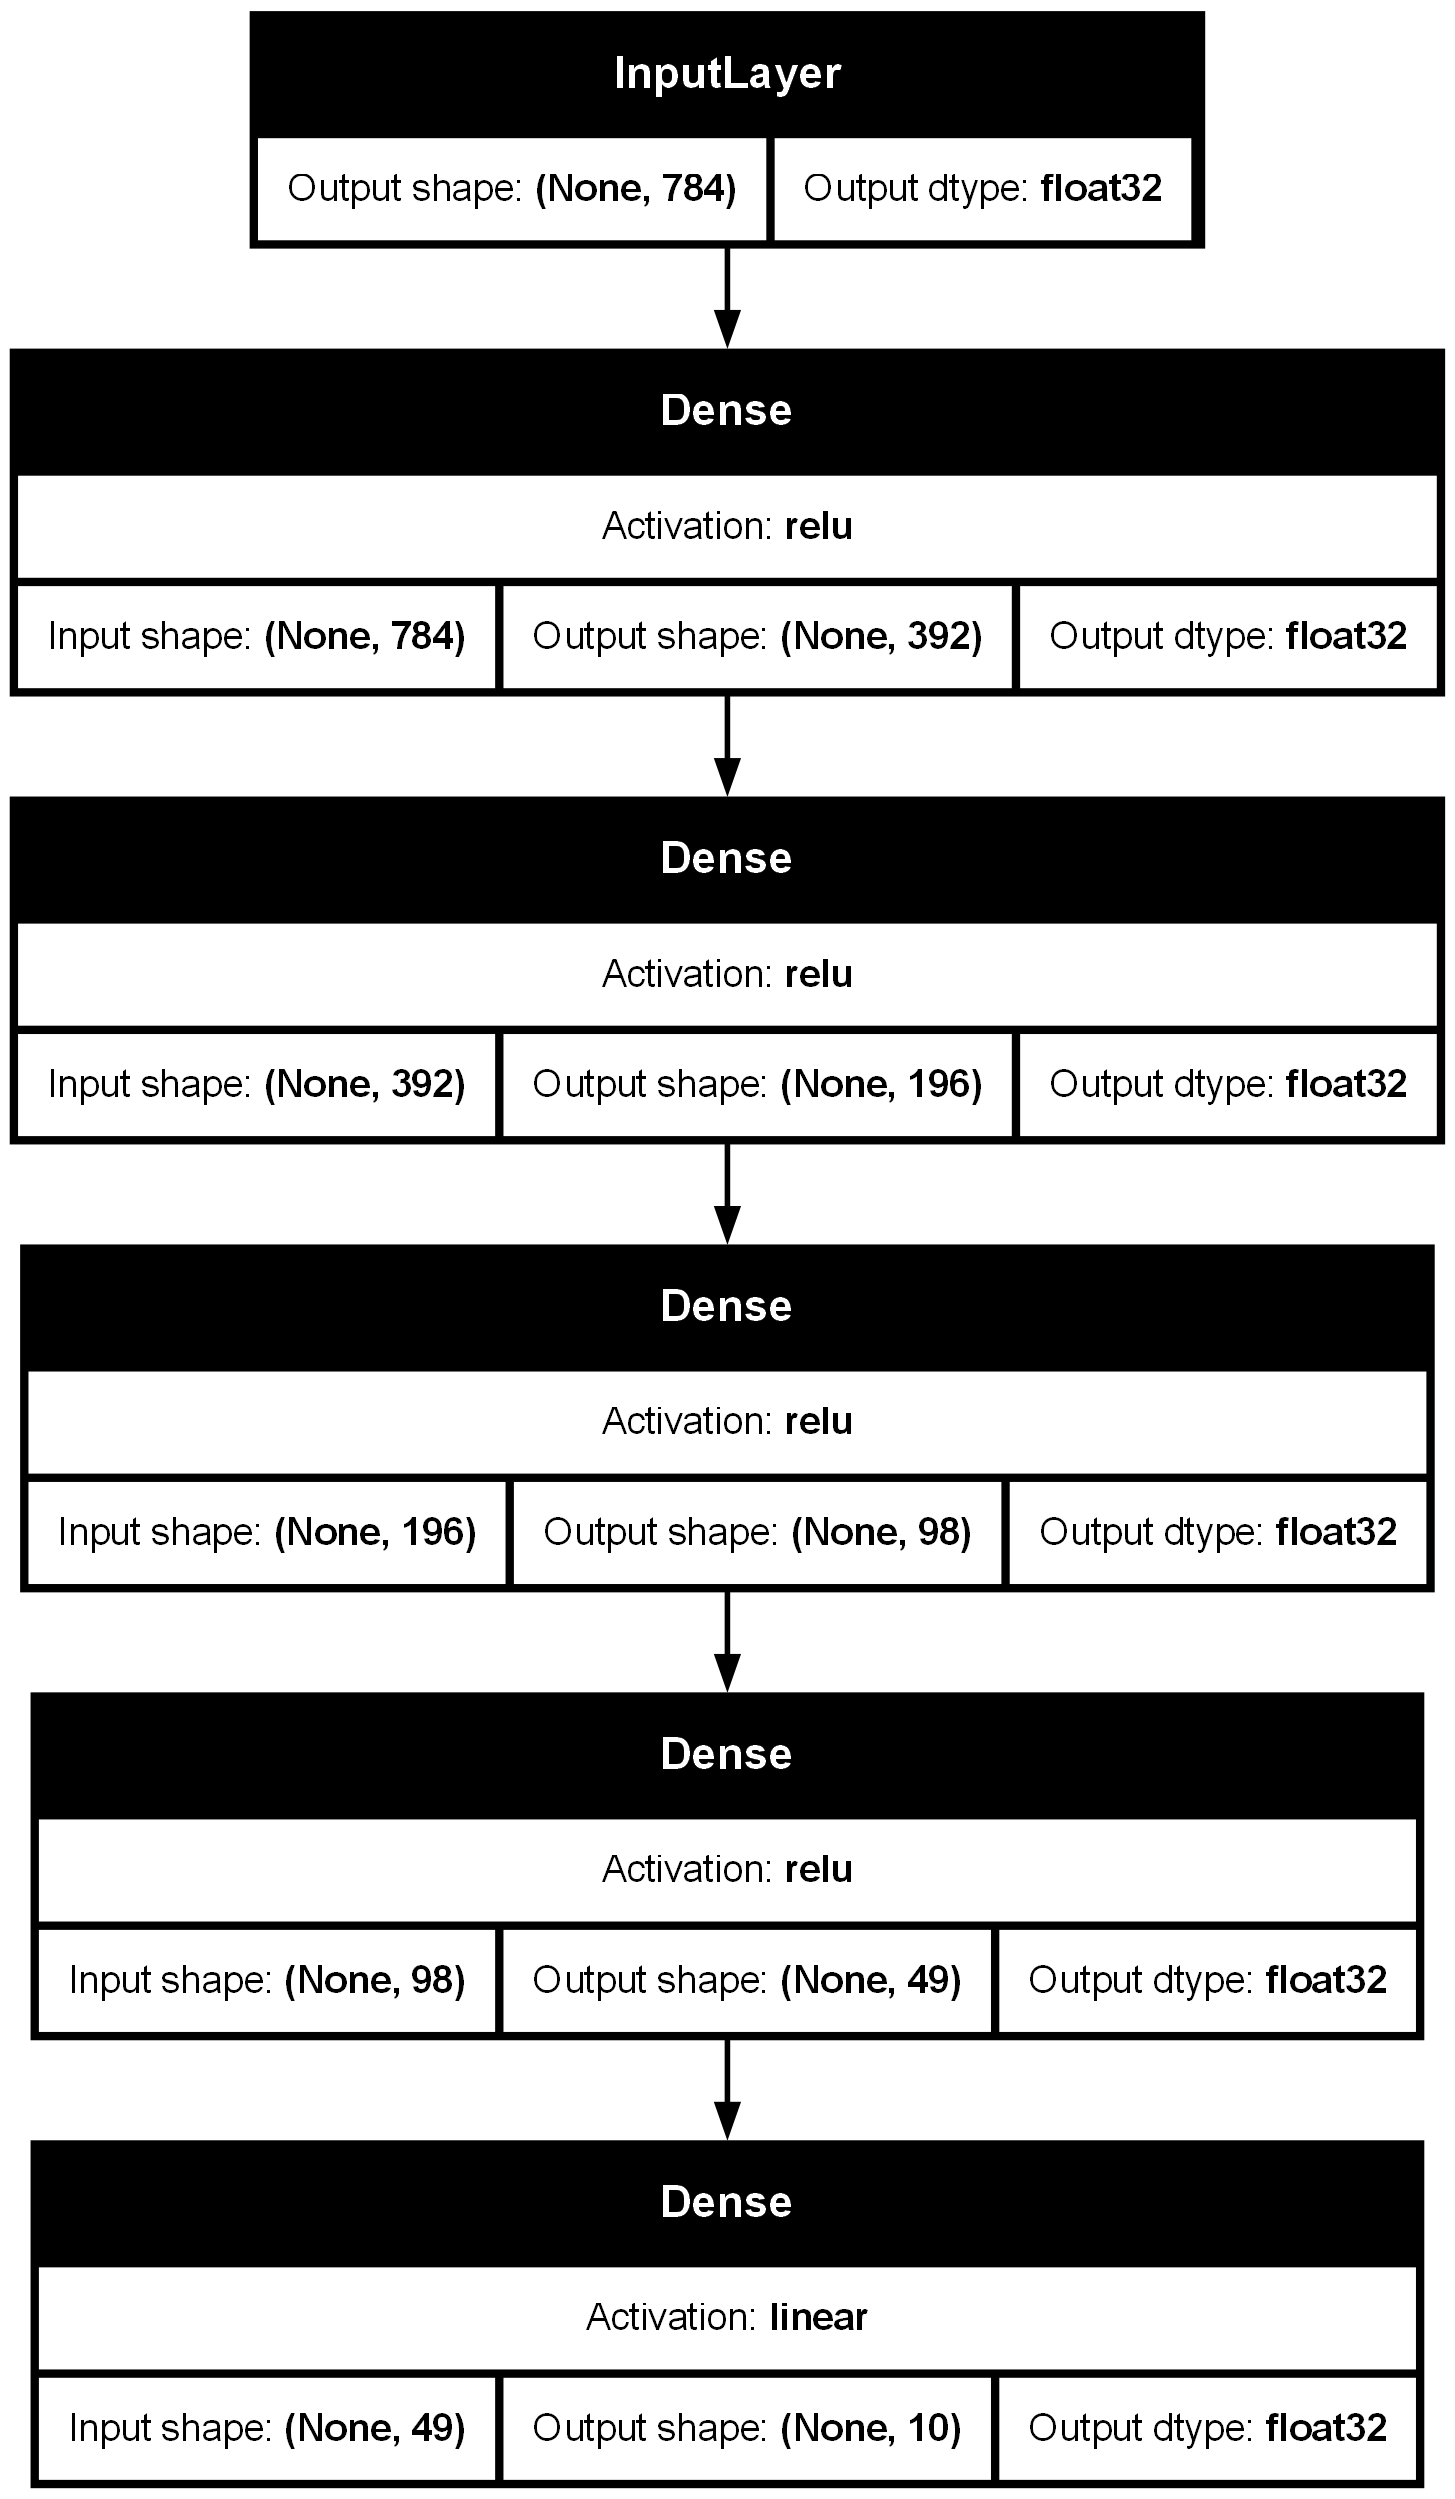

In [20]:
tf.keras.utils.plot_model(
    model, 
    os.path.join(outDir, 'mnist_dataset.png'),
    show_shapes=True, 
    show_dtype=True, 
    show_layer_activations=True
)

$$\text{
    Compiling the model
}
$$

In [21]:
# Optimized for model
optimizer = tf.keras.optimizers.Adam(learning_rate = ALPHA)

# Compile
model.compile(
    optimizer = optimizer,
    loss = loss_fn,
    metrics = ['accuracy']
)

$$\text{
    Fitting the model
}
$$

In [22]:
history = model.fit(
    train_ds, 
    validation_data = test_ds,
    batch_size = BATCH_SIZE,
    verbose = 1,
    epochs =EPOCHS
)

Epoch 1/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.7505 - loss: 0.6808 - val_accuracy: 0.8580 - val_loss: 0.3837
Epoch 2/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.8539 - loss: 0.4027 - val_accuracy: 0.8664 - val_loss: 0.3627
Epoch 3/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.8710 - loss: 0.3535 - val_accuracy: 0.8763 - val_loss: 0.3450
Epoch 4/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.8809 - loss: 0.3248 - val_accuracy: 0.8780 - val_loss: 0.3373
Epoch 5/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.8877 - loss: 0.3034 - val_accuracy: 0.8834 - val_loss: 0.3278
Epoch 6/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.8940 - loss: 0.2850 - val_accuracy: 0.8786 - val_loss: 0.3411
Epoch 7/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.8992 - loss: 0.2694 - val_accuracy: 0.8741 - val_loss: 0.3660
Epoch 8/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.9046 - loss: 0.2560 - 

$$\text{
    Getting history and Plotting Accuracy and Loss Graphs
}
$$

,accuracy,loss,val_accuracy,val_loss
0,0.810021,0.522866,0.858000,0.383735
1,0.858063,0.390040,0.866417,0.362687
2,0.873187,0.348342,0.876250,0.345037


,accuracy,loss,val_accuracy,val_loss
17,0.930667,0.181600,0.87975,0.395855
18,0.932292,0.176875,0.88125,0.406362
19,0.934438,0.172798,0.87650,0.441008


<Axes: >

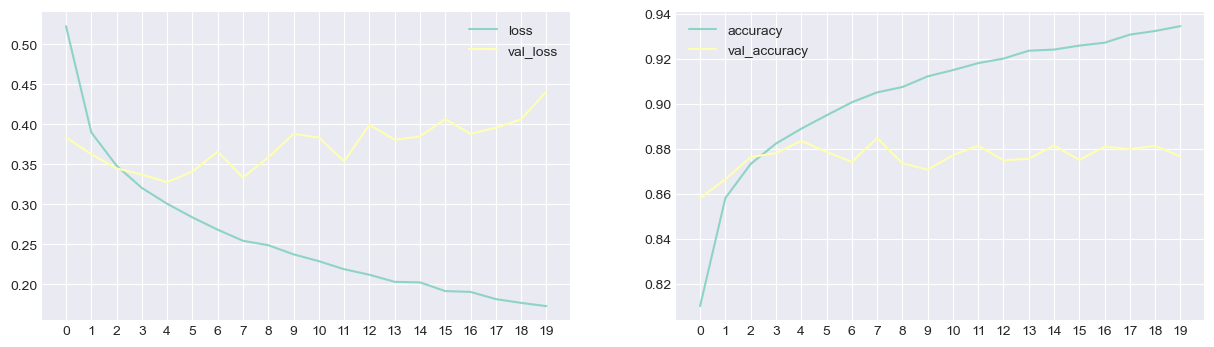

In [23]:
hist_df = pd.DataFrame(history.history) 

display(hist_df.head(3))
display(hist_df.tail(3))

fn_plot_tf_hist(hist_df = hist_df)

In [24]:
prediction_model = tf.keras.Sequential([
    model,
    tf.keras.layers.Softmax()
])
prediction_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ functional (Functional)         │ (None, 10)             │       409,405 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ softmax (Softmax)               │ (None, 10)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 409,405 (1.56 MB)

 Trainable params: 409,405 (1.56 MB)

 Non-trainable params: 0 (0.00 B)

Dataset Train
48000 48000
91.24375


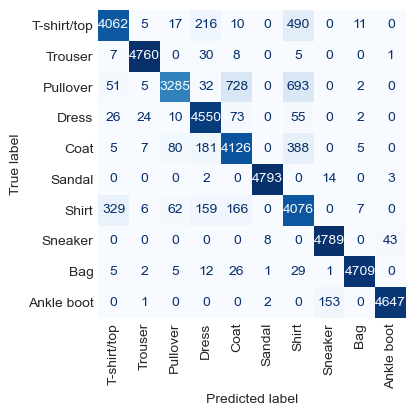

Dataset Test
12000 12000
87.64999999999999


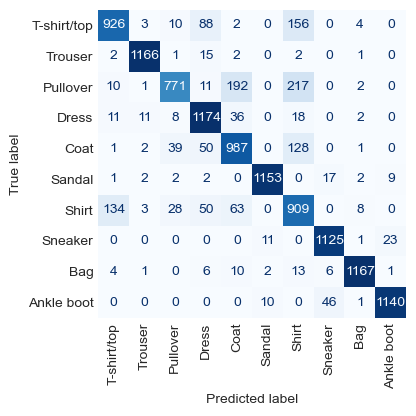

Dataset Validation
10000 10000
87.71


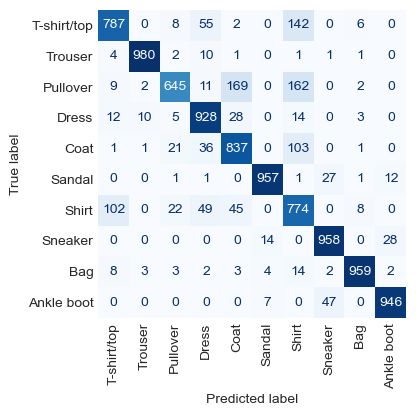

In [25]:
ds = {
    'Train' : train_ds,
    'Test' : test_ds,
    'Validation' : valid_ds
}

for name, data_ds in ds.items():
    print(f'Dataset {name}')
    accuracy_socre_confusion_matrix(data_ds=data_ds, prediction_model=prediction_model, labels=class_names.values())

---

$$\large\text{
    With Regularization
}$$

In [26]:
# inintializer
initializer = tf.keras.initializers.GlorotUniform(seed=RANDOM_STATE)

# regilarization
regularizer = tf.keras.regularizers.l2(l2=0.05) # l -> tune

# Input
inputs = tf.keras.Input(shape=(784,), name='input')


# Hidden Layer
x = tf.keras.layers.Dense(
    392, 
    kernel_initializer=initializer,
    kernel_regularizer=regularizer,
    activation=tf.keras.activations.relu, 
    name='fc_1'
)(inputs)
x = tf.keras.layers.Dense(
    196, 
    kernel_initializer=initializer,
    kernel_regularizer=regularizer,
    activation=tf.keras.activations.relu, 
    name='fc_2'
)(x)
x = tf.keras.layers.Dense(
    98, 
    kernel_initializer=initializer,
    kernel_regularizer=regularizer,
    activation=tf.keras.activations.relu, 
    name='fc_3'
)(x)
x = tf.keras.layers.Dense(
    49, 
    kernel_initializer=initializer,
    kernel_regularizer=regularizer,
    activation=tf.keras.activations.relu, 
    name='fc_4'
)(x)

# Output 
outputs = tf.keras.layers.Dense(
    out_len,
    kernel_initializer=initializer,
    kernel_regularizer=regularizer,
    activation=tf.keras.activations.softmax, 
    name='output'
)(x)
# Model
model = tf.keras.Model(inputs=inputs, outputs=outputs)

In [27]:
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc_1 (Dense)                    │ (None, 392)            │       307,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc_2 (Dense)                    │ (None, 196)            │        77,028 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc_3 (Dense)                    │ (None, 98)             │        19,306 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc_4 (Dense)                    │ (None, 49)             │         4,851 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 10)             │           500 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 409,405 (1.56 MB)

 Trainable params: 409,405 (1.56 MB)

 Non-trainable params: 0 (0.00 B)

$$\text{
    Creating the loss function for the model
}
$$

In [28]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True)

$$\text{
    Compiling the model
}
$$

In [29]:
# Optimized for model
optimizer = tf.keras.optimizers.Adam(learning_rate = ALPHA)

# Compile
model.compile(
    optimizer = optimizer,
    loss = loss_fn,
    metrics = ['accuracy']
)

$$\text{
    Fitting the model
}
$$

In [30]:
history = model.fit(
    train_ds, 
    validation_data = test_ds,
    batch_size = BATCH_SIZE,
    verbose = 1,
    epochs =EPOCHS
)

Epoch 1/20


c:\Users\DAI.STUDENTSDC\.conda\envs\pythonProject\Lib\site-packages\keras\src\backend\tensorflow\nn.py:635: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.5414 - loss: 6.6952 - val_accuracy: 0.5908 - val_loss: 1.9389
Epoch 2/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.6366 - loss: 1.9251 - val_accuracy: 0.6042 - val_loss: 1.9108
Epoch 3/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.6500 - loss: 1.8920 - val_accuracy: 0.6225 - val_loss: 1.8917
Epoch 4/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.6564 - loss: 1.8692 - val_accuracy: 0.6509 - val_loss: 1.8616
Epoch 5/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.6625 - loss: 1.8529 - val_accuracy: 0.6578 - val_loss: 1.8506
Epoch 6/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.6648 - loss: 1.8453 - val_accuracy: 0.6566 - val_loss: 1.8466
Epoch 7/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.6657 - loss: 1.8406 - val_accuracy: 0.6556 - val_loss: 1.8443
Epoch 8/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.6650 - loss: 1.8365 - val_accurac

$$\text{
    Getting history and Plotting Accuracy and Loss Graphs
}
$$

,accuracy,loss,val_accuracy,val_loss
0,0.588208,3.084032,0.590833,1.938910
1,0.642125,1.918575,0.604167,1.910785
2,0.650792,1.890449,0.622500,1.891664


,accuracy,loss,val_accuracy,val_loss
17,0.670583,1.825699,0.652417,1.834045
18,0.670000,1.825000,0.652667,1.832954
19,0.668875,1.824250,0.651583,1.832637


<Axes: >

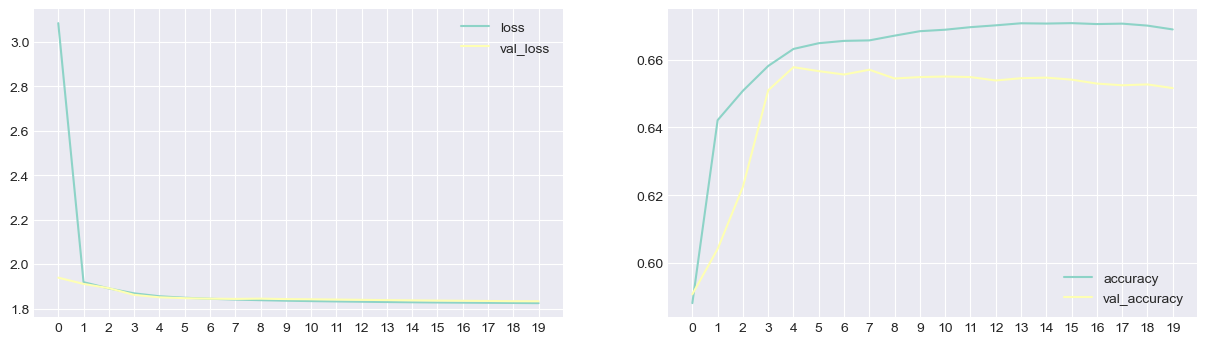

In [31]:
hist_df = pd.DataFrame(history.history) 

display(hist_df.head(3))
display(hist_df.tail(3))

fn_plot_tf_hist(hist_df = hist_df)

$$\text{
Creating the Prediction Model
}
$$

In [32]:
prediction_model = tf.keras.Sequential([
    model,
    tf.keras.layers.Softmax()
])
prediction_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ functional_2 (Functional)       │ (None, 10)             │       409,405 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ softmax_1 (Softmax)             │ (None, 10)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 409,405 (1.56 MB)

 Trainable params: 409,405 (1.56 MB)

 Non-trainable params: 0 (0.00 B)

$$
\text{
Accuracy and Confusion Matrix
}
$$

Dataset Train
48000 48000
65.08333333333334


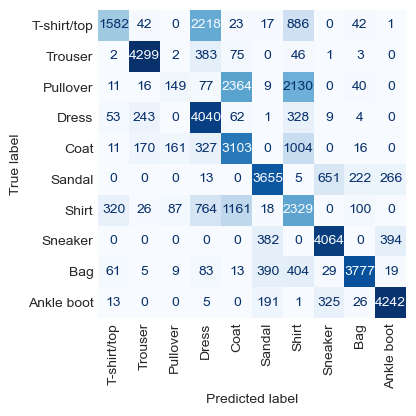

Dataset Test
12000 12000
65.15833333333333


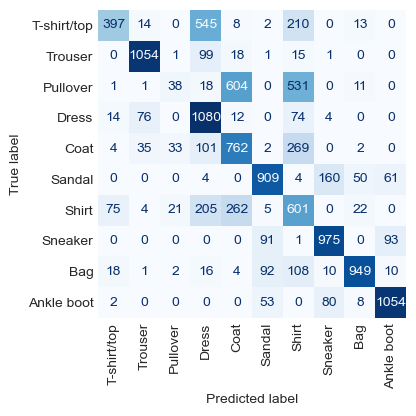

Dataset Validation
10000 10000
65.38000000000001


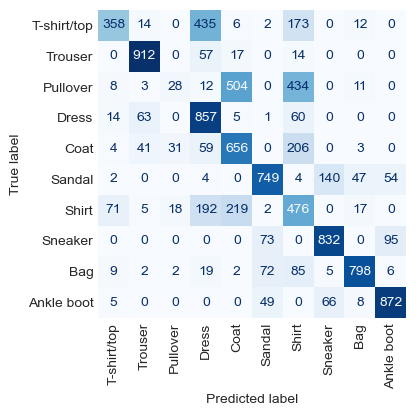

In [33]:
ds = {
    'Train' : train_ds,
    'Test' : test_ds,
    'Validation' : valid_ds
}

for name, data_ds in ds.items():
    print(f'Dataset {name}')
    accuracy_socre_confusion_matrix(data_ds=data_ds, prediction_model=prediction_model, labels=class_names.values())

---

$$\large\text{Batch Normalization}$$


In [34]:
# clear memory
del model
gc.collect()
gc.collect()

# inintializer
initializer = tf.keras.initializers.GlorotUniform(seed=RANDOM_STATE)

# Input
inputs = tf.keras.Input(shape=(784,), name='input')



# Set 1st Hidden Layer
x = tf.keras.layers.Dense(
    392, 
    kernel_initializer=initializer,
    name='fc_1'
)(inputs)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation(activation=tf.keras.activations.relu)(x)

# Set 2nd Hidden Layer
x = tf.keras.layers.Dense(
    196, 
    kernel_initializer=initializer,
    name='fc_2'
)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation(activation=tf.keras.activations.relu)(x)

# Set 3rd Hidden Layer
x = tf.keras.layers.Dense(
    98, 
    kernel_initializer=initializer,
    name='fc_3'
)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation(activation=tf.keras.activations.relu)(x)

# Set 4th Hidden Layer
x = tf.keras.layers.Dense(
    49, 
    kernel_initializer=initializer,
    name='fc_4'
)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation(activation=tf.keras.activations.relu)(x)

# Output 
outputs = tf.keras.layers.Dense(
    out_len, 
    kernel_initializer=initializer,
    name='output'
)(x)

# Model
model = tf.keras.Model(inputs=inputs, outputs=outputs)

In [35]:
model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc_1 (Dense)                    │ (None, 392)            │       307,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 392)            │         1,568 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 392)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc_2 (Dense)                    │ (None, 196)            │        77,028 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 196)            │           784 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 196)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc_3 (Dense)                    │ (None, 98)             │        19,306 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 98)             │           392 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 98)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc_4 (Dense)                    │ (None, 49)             │         4,851 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 49)             │           196 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 49)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 10)             │           500 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 412,345 (1.57 MB)

 Trainable params: 410,875 (1.57 MB)

 Non-trainable params: 1,470 (5.74 KB)

$$\text{
    Creating the loss function for the model
}
$$

In [36]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True)

$$\text{
    Compiling the model
}
$$

In [37]:
# Optimized for model
optimizer = tf.keras.optimizers.Adam(learning_rate = ALPHA)

# Compile
model.compile(
    optimizer = optimizer,
    loss = loss_fn,
    metrics = ['accuracy']
)

$$\text{
    Fitting the model
}
$$

In [38]:
history = model.fit(
    train_ds, 
    validation_data = test_ds,
    batch_size = BATCH_SIZE,
    verbose = 1,
    epochs =EPOCHS
)

Epoch 1/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.7782 - loss: 0.6661 - val_accuracy: 0.8567 - val_loss: 0.3862
Epoch 2/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.8560 - loss: 0.3927 - val_accuracy: 0.8551 - val_loss: 0.3874
Epoch 3/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.8789 - loss: 0.3320 - val_accuracy: 0.8363 - val_loss: 0.4422
Epoch 4/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.8939 - loss: 0.2899 - val_accuracy: 0.8565 - val_loss: 0.4134
Epoch 5/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.9063 - loss: 0.2547 - val_accuracy: 0.8483 - val_loss: 0.4484
Epoch 6/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.9145 - loss: 0.2271 - val_accuracy: 0.8588 - val_loss: 0.4242
Epoch 7/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.9247 - loss: 0.2016 - val_accuracy: 0.8636 - val_loss: 0.4331
Epoch 8/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.9329 - loss: 0

$$\text{
    Getting history and Plotting Accuracy and Loss Graphs
}
$$

,accuracy,loss,val_accuracy,val_loss
0,0.817542,0.522679,0.856667,0.386155
1,0.862792,0.377034,0.855083,0.387390
2,0.882896,0.323454,0.836333,0.442196


,accuracy,loss,val_accuracy,val_loss
17,0.973583,0.071126,0.883333,0.550634
18,0.974813,0.067568,0.873167,0.634803
19,0.976708,0.062811,0.866750,0.656400


<Axes: >

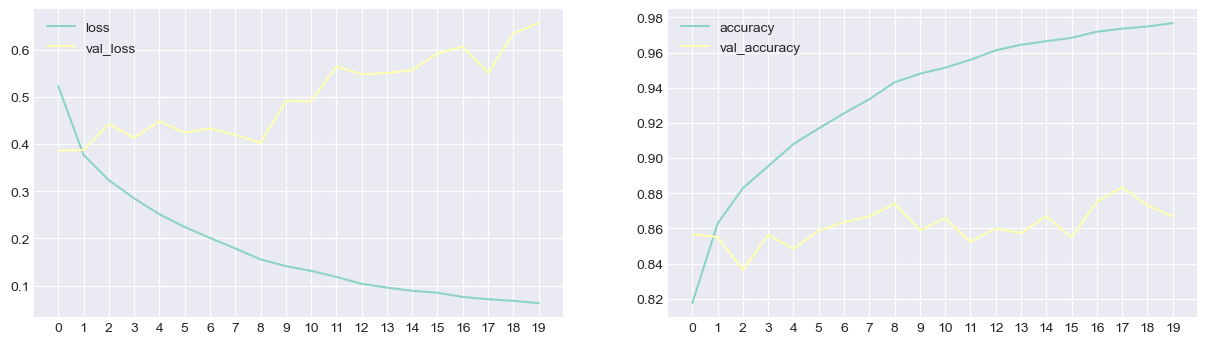

In [39]:
hist_df = pd.DataFrame(history.history) 

display(hist_df.head(3))
display(hist_df.tail(3))

fn_plot_tf_hist(hist_df = hist_df)

$$\text{
Creating the Prediction Model
}
$$

In [40]:
prediction_model = tf.keras.Sequential([
    model,
    tf.keras.layers.Softmax()
])
prediction_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ functional_4 (Functional)       │ (None, 10)             │       412,345 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ softmax_2 (Softmax)             │ (None, 10)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 412,345 (1.57 MB)

 Trainable params: 410,875 (1.57 MB)

 Non-trainable params: 1,470 (5.74 KB)

$$
\text{
Accuracy and Confusion Matrix
}
$$

Dataset Train
48000 48000
92.34583333333333


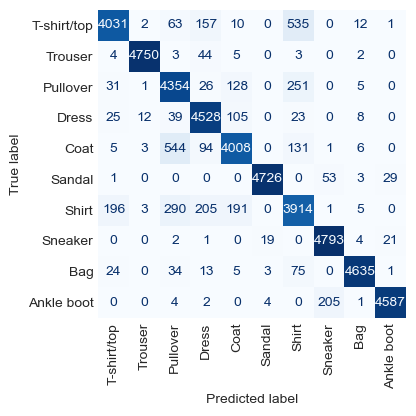

Dataset Test
12000 12000
86.675


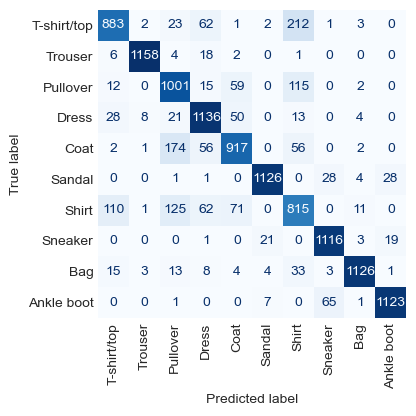

Dataset Validation
10000 10000
87.36


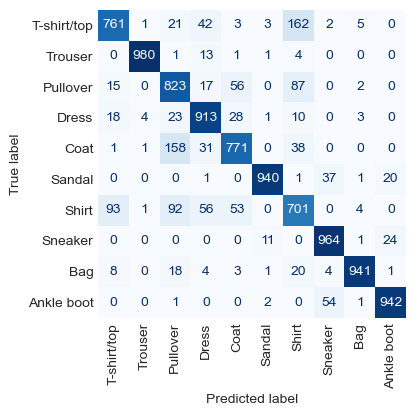

In [41]:
ds = {
    'Train' : train_ds,
    'Test' : test_ds,
    'Validation' : valid_ds
}

for name, data_ds in ds.items():
    print(f'Dataset {name}')
    accuracy_socre_confusion_matrix(data_ds=data_ds, prediction_model=prediction_model, labels=class_names.values())

---


$$\large\text{
    Model with Dropout
}$$

In [74]:
drops = [
    [0.3,0.3,0.3,0.3,0.3],
    [0.2,0.3,0.4,0.5,0.6],
    [0.6,0.5,0.4,0.3,0.2]
]

DOR1, DOR2, DOR3, DOR4, DOR5 = drops[1] # Best

# clear memory
del model
gc.collect()
gc.collect()

# inintializer
initializer = tf.keras.initializers.GlorotUniform(seed=RANDOM_STATE)

# Input
inputs = tf.keras.Input(shape=(784,), name='input')


# Set 1st Hidden Layer
x = tf.keras.layers.Dense(
    392, 
    kernel_initializer=initializer,
    name='fc_1'
)(inputs)
x = tf.keras.layers.Activation(activation=tf.keras.activations.relu)(x)
x = tf.keras.layers.Dropout(rate=DOR1)(x)

# Set 2nd Hidden Layer
x = tf.keras.layers.Dense(
    196, 
    kernel_initializer=initializer,
    name='fc_2'
)(x)
x = tf.keras.layers.Activation(activation=tf.keras.activations.relu)(x)
x = tf.keras.layers.Dropout(rate=DOR2)(x)

# Set 3rd Hidden Layer
x = tf.keras.layers.Dense(
    98, 
    kernel_initializer=initializer,
    name='fc_3'
)(x)
x = tf.keras.layers.Activation(activation=tf.keras.activations.relu)(x)
x = tf.keras.layers.Dropout(rate=DOR3)(x)

# Set 4th Hidden Layer
x = tf.keras.layers.Dense(
    49, 
    kernel_initializer=initializer,
    name='fc_4'
)(x)
x = tf.keras.layers.Activation(activation=tf.keras.activations.relu)(x)
x = tf.keras.layers.Dropout(rate=DOR4)(x)

# Output 
outputs = tf.keras.layers.Dense(
    out_len, 
    kernel_initializer=initializer,
    name='output'
)(x)

# Model
model = tf.keras.Model(inputs=inputs, outputs=outputs)

In [75]:
model.summary()

Model: "functional_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc_1 (Dense)                    │ (None, 392)            │       307,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_32 (Activation)      │ (None, 392)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_28 (Dropout)            │ (None, 392)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc_2 (Dense)                    │ (None, 196)            │        77,028 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_33 (Activation)      │ (None, 196)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_29 (Dropout)            │ (None, 196)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc_3 (Dense)                    │ (None, 98)             │        19,306 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_34 (Activation)      │ (None, 98)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_30 (Dropout)            │ (None, 98)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc_4 (Dense)                    │ (None, 49)             │         4,851 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_35 (Activation)      │ (None, 49)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_31 (Dropout)            │ (None, 49)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 10)             │           500 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 409,405 (1.56 MB)

 Trainable params: 409,405 (1.56 MB)

 Non-trainable params: 0 (0.00 B)

$$\text{
    Creating the loss function for the model
}
$$

In [76]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True)

$$\text{
    Compiling the model
}
$$

In [77]:
# Optimized for model
optimizer = tf.keras.optimizers.Adam(learning_rate = ALPHA)

# Compile
model.compile(
    optimizer = optimizer,
    loss = loss_fn,
    metrics = ['accuracy']
)

$$\text{
    Fitting the model
}
$$

In [78]:
history = model.fit(
    train_ds, 
    validation_data = test_ds,
    batch_size = BATCH_SIZE,
    verbose = 1,
    epochs =EPOCHS
)

Epoch 1/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.5628 - loss: 1.1970 - val_accuracy: 0.8223 - val_loss: 0.5186
Epoch 2/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.7976 - loss: 0.5985 - val_accuracy: 0.8473 - val_loss: 0.4247
Epoch 3/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.8203 - loss: 0.5270 - val_accuracy: 0.8579 - val_loss: 0.3896
Epoch 4/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.8343 - loss: 0.4944 - val_accuracy: 0.8597 - val_loss: 0.3957
Epoch 5/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.8452 - loss: 0.4657 - val_accuracy: 0.8626 - val_loss: 0.3896
Epoch 6/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.8475 - loss: 0.4520 - val_accuracy: 0.8636 - val_loss: 0.3855
Epoch 7/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.8541 - loss: 0.4367 - val_accuracy: 0.8666 - val_loss: 0.3785
Epoch 8/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.8571 - loss: 0.4212 -

$$\text{
    Getting history and Plotting Accuracy and Loss Graphs
}
$$

,accuracy,loss,val_accuracy,val_loss
0,0.686917,0.871826,0.822250,0.518587
1,0.805229,0.577273,0.847333,0.424659
2,0.824479,0.521257,0.857917,0.389582


,accuracy,loss,val_accuracy,val_loss
17,0.878313,0.358216,0.875750,0.381879
18,0.877729,0.354780,0.881000,0.351776
19,0.881021,0.347002,0.883917,0.353944


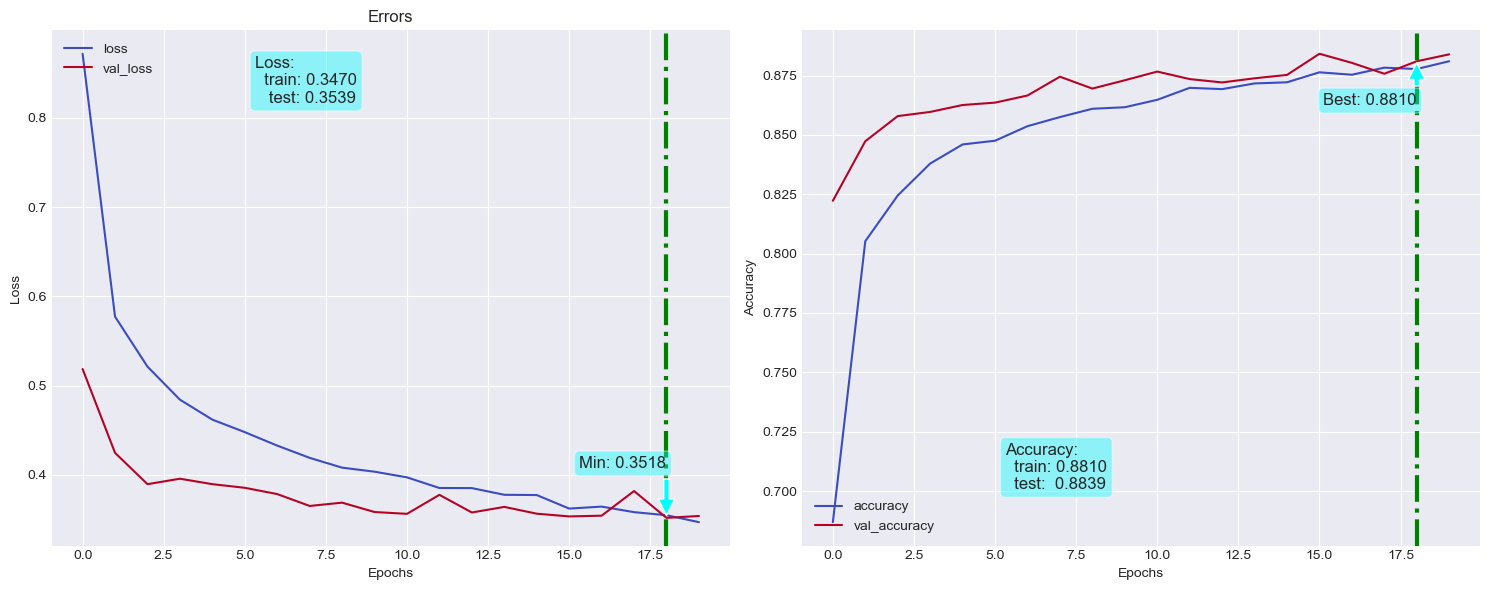

In [79]:
hist_df = pd.DataFrame(history.history) 

display(hist_df.head(3))
display(hist_df.tail(3))

fn_plot_tf_hist(hist_df = hist_df)

$$\text{
Creating the Prediction Model
}
$$

In [80]:
prediction_model = tf.keras.Sequential([
    model,
    tf.keras.layers.Softmax()
])
prediction_model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ functional_16 (Functional)      │ (None, 10)             │       409,405 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ softmax_6 (Softmax)             │ (None, 10)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 409,405 (1.56 MB)

 Trainable params: 409,405 (1.56 MB)

 Non-trainable params: 0 (0.00 B)

$$
\text{
Accuracy and Confusion Matrix
}
$$

Dataset Train
48000 48000
90.17083333333333


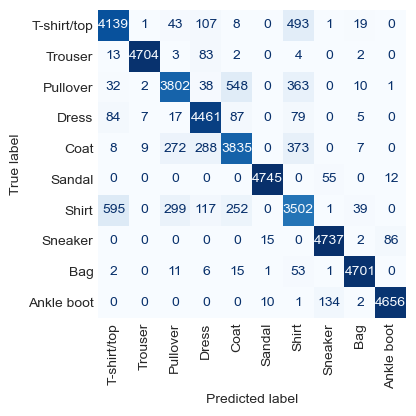

Dataset Test
12000 12000
88.39166666666667


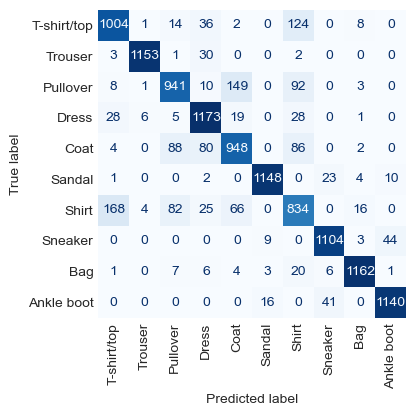

Dataset Validation
10000 10000
88.24


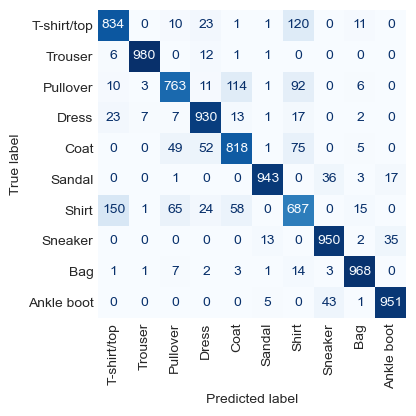

In [81]:
ds = {
    'Train' : train_ds,
    'Test' : test_ds,
    'Validation' : valid_ds
}

for name, data_ds in ds.items():
    print(f'Dataset {name}')
    accuracy_socre_confusion_matrix(data_ds=data_ds, prediction_model=prediction_model, labels=class_names.values())

---


$$\Large\text{
    Model with Dropout and Early Stopping
}$$

In [83]:
drops = [
    [0.3,0.3,0.3,0.3,0.3],
    [0.2,0.3,0.4,0.5,0.6],
    [0.6,0.5,0.4,0.3,0.2]
]

DOR1, DOR2, DOR3, DOR4, DOR5 = drops[1] # Best

# clear memory
del model
gc.collect()
gc.collect()

# inintializer
initializer = tf.keras.initializers.GlorotUniform(seed=RANDOM_STATE)

# Input
inputs = tf.keras.Input(shape=(784,), name='input')


# Set 1st Hidden Layer
x = tf.keras.layers.Dense(
    392, 
    kernel_initializer=initializer,
    name='fc_1'
)(inputs)
x = tf.keras.layers.Activation(activation=tf.keras.activations.relu)(x)
x = tf.keras.layers.Dropout(rate=DOR1)(x)

# Set 2nd Hidden Layer
x = tf.keras.layers.Dense(
    196, 
    kernel_initializer=initializer,
    name='fc_2'
)(x)
x = tf.keras.layers.Activation(activation=tf.keras.activations.relu)(x)
x = tf.keras.layers.Dropout(rate=DOR2)(x)

# Set 3rd Hidden Layer
x = tf.keras.layers.Dense(
    98, 
    kernel_initializer=initializer,
    name='fc_3'
)(x)
x = tf.keras.layers.Activation(activation=tf.keras.activations.relu)(x)
x = tf.keras.layers.Dropout(rate=DOR3)(x)

# Set 4th Hidden Layer
x = tf.keras.layers.Dense(
    49, 
    kernel_initializer=initializer,
    name='fc_4'
)(x)
x = tf.keras.layers.Activation(activation=tf.keras.activations.relu)(x)
x = tf.keras.layers.Dropout(rate=DOR4)(x)

# Output 
outputs = tf.keras.layers.Dense(
    out_len, 
    kernel_initializer=initializer,
    name='output'
)(x)

# Model
model = tf.keras.Model(inputs=inputs, outputs=outputs)

In [84]:
model.summary()

Model: "functional_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc_1 (Dense)                    │ (None, 392)            │       307,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_36 (Activation)      │ (None, 392)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_32 (Dropout)            │ (None, 392)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc_2 (Dense)                    │ (None, 196)            │        77,028 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_37 (Activation)      │ (None, 196)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_33 (Dropout)            │ (None, 196)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc_3 (Dense)                    │ (None, 98)             │        19,306 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_38 (Activation)      │ (None, 98)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_34 (Dropout)            │ (None, 98)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc_4 (Dense)                    │ (None, 49)             │         4,851 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_39 (Activation)      │ (None, 49)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_35 (Dropout)            │ (None, 49)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 10)             │           500 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 409,405 (1.56 MB)

 Trainable params: 409,405 (1.56 MB)

 Non-trainable params: 0 (0.00 B)

$$\text{
    Creating the loss function for the model
}
$$

In [85]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True)

$$\text{
    Fitting the model
}
$$

In [86]:
chkptPath = os.path.join(modelDir, subDir, 'all_in.keras')

checpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    chkptPath,
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0.0001,
    patience=PATIENCE,
    verbose=1, 
    restore_best_weights=True
)

lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=LR_FACTOR,
    patience=LR_PATIENCE,
    verbose=1,
)

$$\text{
    Compiling the model
}
$$

In [87]:
# Optimized for model
optimizer = tf.keras.optimizers.Adam(learning_rate = ALPHA)

# Compile
model.compile(
    optimizer = optimizer,
    loss = loss_fn,
    metrics = ['accuracy']
)

$$\text{
    Fitting the model
}
$$

In [88]:
history = model.fit(
    train_ds, 
    validation_data = test_ds,
    batch_size = BATCH_SIZE,
    verbose = 1,
    epochs =EPOCHS,
    callbacks = [
        checpoint_cb,
        early_stopping_cb,
        lr_scheduler
    ]
)

Epoch 1/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5578 - loss: 1.1995
Epoch 1: val_loss improved from inf to 0.51492, saving model to ../models\mnist_fashion\all_in.keras
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - accuracy: 0.5579 - loss: 1.1993 - val_accuracy: 0.8166 - val_loss: 0.5149 - learning_rate: 0.0010
Epoch 2/20
1494/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7870 - loss: 0.6142
Epoch 2: val_loss improved from 0.51492 to 0.43736, saving model to ../models\mnist_fashion\all_in.keras
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.7871 - loss: 0.6140 - val_accuracy: 0.8422 - val_loss: 0.4374 - learning_rate: 0.0010
Epoch 3/20
1495/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8201 - loss: 0.5414
Epoch 3: val_loss improved from 0.43736 to 0.39823, saving model to ../models\mnist_fashion\all_in.keras
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.8201 - loss: 0.5413 - val_accuracy: 0.8552 - val_loss: 0.3982 - learning_rate: 0

$$\text{
    Getting history and Plotting Accuracy and Loss Graphs
}
$$

,accuracy,loss,val_accuracy,val_loss,learning_rate
0,0.682000,0.875779,0.816583,0.514924,0.001
1,0.798604,0.586674,0.842250,0.437359,0.001
2,0.825271,0.525506,0.855167,0.398234,0.001


,accuracy,loss,val_accuracy,val_loss,learning_rate
17,0.875604,0.366129,0.882333,0.353887,0.001
18,0.877125,0.356198,0.878750,0.364608,0.001
19,0.875750,0.361060,0.880583,0.354648,0.001


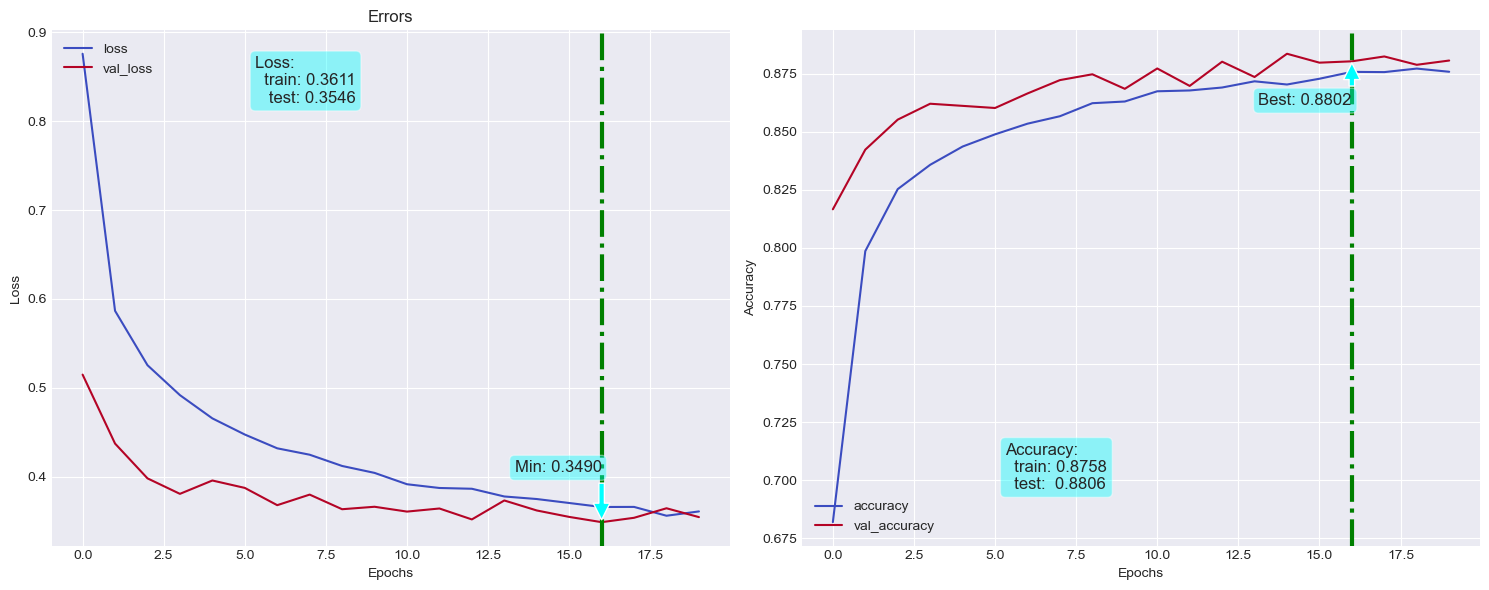

In [89]:
hist_df = pd.DataFrame(history.history) 

display(hist_df.head(3))
display(hist_df.tail(3))

fn_plot_tf_hist(hist_df = hist_df)

$$\text{
Creating the Prediction Model
}
$$

In [90]:
prediction_model = tf.keras.Sequential([
    model,
    tf.keras.layers.Softmax()
])
prediction_model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ functional_18 (Functional)      │ (None, 10)             │       409,405 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ softmax_7 (Softmax)             │ (None, 10)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 409,405 (1.56 MB)

 Trainable params: 409,405 (1.56 MB)

 Non-trainable params: 0 (0.00 B)

$$
\text{
Accuracy and Confusion Matrix
}
$$

Dataset Train
48000 48000
89.40208333333334


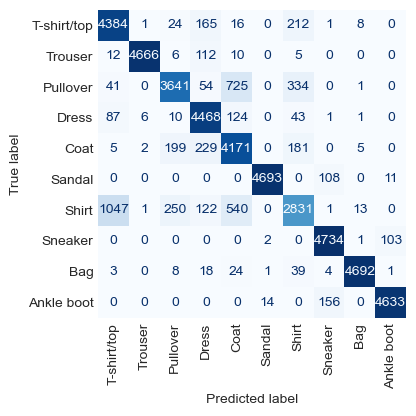

Dataset Test
12000 12000
88.02499999999999


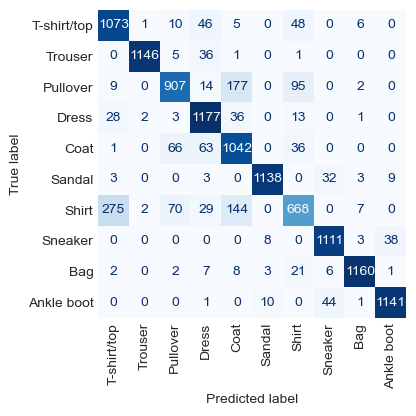

Dataset Validation
10000 10000
87.64999999999999


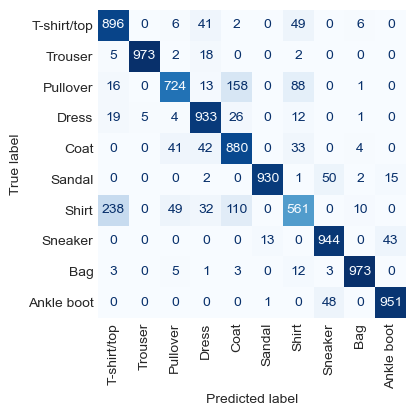

In [91]:
ds = {
    'Train' : train_ds,
    'Test' : test_ds,
    'Validation' : valid_ds
}

for name, data_ds in ds.items():
    print(f'Dataset {name}')
    accuracy_socre_confusion_matrix(data_ds=data_ds, prediction_model=prediction_model, labels=class_names.values())